In [ ]:
"""
Dedalus script simulating 2D horizontally-periodic Rayleigh-Benard convection.
This script demonstrates solving a 2D Cartesian initial value problem. It can
be ran serially or in parallel, and uses the built-in analysis framework to save
data snapshots to HDF5 files. The `plot_snapshots.py` script can be used to
produce plots from the saved data. It should take about 5 cpu-minutes to run.

For incompressible hydro with two boundaries, we need two tau terms for each the
velocity and buoyancy. Here we choose to use a first-order formulation, putting
one tau term each on auxiliary first-order gradient variables and the others in
the PDE, and lifting them all to the first derivative basis. This formulation puts
a tau term in the divergence constraint, as required for this geometry.

To run and plot using e.g. 4 processes:
    $ mpiexec -n 4 python3 rayleigh_benard.py
    $ mpiexec -n 4 python3 plot_snapshots.py snapshots/*.h5
"""


In [1]:
import numpy as np
import dedalus.public as d3
import logging
logger = logging.getLogger(__name__)
import copy
import h5py
import numpy as np
import matplotlib

import matplotlib.pyplot as plt
from dedalus.extras import plot_tools
import os
from os import listdir


In [2]:
matplotlib.use('Agg')

In [3]:
# Parameters
Lx, Ly, Lz = 4,4,1
Nx, Ny, Nz = 128, 128, 32

Ra_D = -1.24e5
Prandtl = 0.7
N_s2 = 4

D_0 = 0
D_H = 1
M_0 = 0
M_H = -1

dealias = 3/2
stop_sim_time = 50
timestepper = d3.RK222
max_timestep = 0.125
dtype = np.float64

In [4]:
# Bases
coords = d3.CartesianCoordinates('x','y', 'z')
dist = d3.Distributor(coords, dtype=dtype)
xbasis = d3.RealFourier(coords['x'], size=Nx, bounds=(0, Lx), dealias=dealias)
ybasis = d3.RealFourier(coords['y'], size=Ny, bounds=(0, Ly), dealias=dealias)
zbasis = d3.ChebyshevT(coords['z'], size=Nz, bounds=(0, Lz), dealias=dealias)

In [5]:
# Fields
p = dist.Field(name='p', bases=(xbasis,ybasis,zbasis))
D = dist.Field(name='D', bases=(xbasis,ybasis,zbasis))
M = dist.Field(name='M', bases=(xbasis,ybasis,zbasis))
u = dist.VectorField(coords, name='u', bases=(xbasis,ybasis,zbasis))
Z = dist.Field(name='Z', bases=zbasis)
tau_p = dist.Field(name='tau_p')
tau_B1 = dist.Field(name='tau_B1', bases=(xbasis,ybasis))
tau_B2 = dist.Field(name='tau_B2', bases=(xbasis,ybasis))
tau_D1 = dist.Field(name='tau_D1', bases=(xbasis,ybasis))
tau_D2 = dist.Field(name='tau_D2', bases=(xbasis,ybasis))
tau_M1 = dist.Field(name='tau_M1', bases=(xbasis,ybasis))
tau_M2 = dist.Field(name='tau_M2', bases=(xbasis,ybasis))
tau_u1 = dist.VectorField(coords, name='tau_u1', bases=(xbasis,ybasis))
tau_u2 = dist.VectorField(coords, name='tau_u2', bases=(xbasis,ybasis))

# Substitutions
kappa = (Ra_D * Prandtl/((D_0-D_H)*Lz**3))**(-1/2)
nu = (Ra_D / (Prandtl*(D_0-D_H)*Lz**3))**(-1/2)

      
#Kuo_Bretherton Equilibrium

#Ra_M
Ra_M = Ra_D*(M_0-M_H)/(D_0-D_H)
G_D=(D_0-D_H)/Lz
G_M=(M_0-M_H)/Lz
Ra_BV=N_s2*Lz**4/(nu*kappa)
print(Ra_M)
print(Ra_BV)

x,z = dist.local_grids(xbasis,zbasis)
Z['g']=z
Z.change_scales(3/2)

ex,ey,ez = coords.unit_vector_fields(dist)
lift_basis = zbasis.derivative_basis(1)
lift = lambda A: d3.Lift(A, lift_basis, -1)

B_op = (np.absolute(D - M - N_s2*Z)+ M + D - N_s2*Z)/2

Max = lambda A,B: (abs(A-N_s2*Z-B)+A-N_s2*Z+B)/2
eva = lambda A: A.evaluate()

uz = u@ez

grad_u = d3.grad(u) + ez*lift(tau_u1) # First-order reduction
grad_M = d3.grad(M) + ez*lift(tau_M1) # First-order reduction
grad_D = d3.grad(D) + ez*lift(tau_D1) # First-order reduction

124000.0
496000.00000000006


In [6]:
# Problem
# First-order form: "div(f)" becomes "trace(grad_f)"
# First-order form: "lap(f)" becomes "div(grad_f)"
problem = d3.IVP([p, M, D, u, tau_p, tau_M1, tau_M2, tau_D1, tau_D2, tau_u1, tau_u2], namespace=locals())
problem.add_equation("trace(grad_u) + tau_p= 0")
problem.add_equation("dt(M) - kappa*div(grad_M) + lift(tau_M2) - G_M*uz= - u@grad(M)")
problem.add_equation("dt(D) - kappa*div(grad_D) + lift(tau_D2) - G_D*uz= - u@grad(D)")
problem.add_equation("dt(u) - nu*div(grad_u) + grad(p)  + lift(tau_u2) = - u@grad(u)+ B_op*ez")
problem.add_equation("M(z=0) = M_0")
problem.add_equation("D(z=0) = D_0")
problem.add_equation("u(z=0) = 0")
problem.add_equation("M(z=Lz) = M_H")
problem.add_equation("D(z=Lz) = D_H")
problem.add_equation("u(z=Lz)= 0")
problem.add_equation("integ(p) = 0") # Pressure gauge

{'LHS': Integrate(Integrate(Integrate(<Field 5239821776>))),
 'RHS': 0,
 'condition': 'True',
 'tensorsig': (),
 'dtype': numpy.float64,
 'M': 0,
 'L': Integrate(Integrate(Integrate(<Field 5239821776>))),
 'F': <Field 5238364752>,
 'domain': <dedalus.core.domain.Domain at 0x138517250>,
 'matrix_dependence': array([ True,  True,  True]),
 'matrix_coupling': array([False, False,  True])}

In [7]:
# Solver
solver = problem.build_solver(timestepper)
solver.stop_sim_time = stop_sim_time


2023-06-26 15:27:06,786 subsystems 0/1 INFO :: Building subproblem matrices 1/4096 (~0%) Elapsed: 0s, Remaining: 14m 33s, Rate: 4.7e+00/s
2023-06-26 15:27:16,660 subsystems 0/1 INFO :: Building subproblem matrices 72/4096 (~2%) Elapsed: 10s, Remaining: 9m 24s, Rate: 7.1e+00/s
2023-06-26 15:27:26,574 subsystems 0/1 INFO :: Building subproblem matrices 118/4096 (~3%) Elapsed: 20s, Remaining: 11m 14s, Rate: 5.9e+00/s
2023-06-26 15:27:36,594 subsystems 0/1 INFO :: Building subproblem matrices 194/4096 (~5%) Elapsed: 30s, Remaining: 10m 04s, Rate: 6.5e+00/s
2023-06-26 15:27:46,640 subsystems 0/1 INFO :: Building subproblem matrices 274/4096 (~7%) Elapsed: 40s, Remaining: 9m 19s, Rate: 6.8e+00/s
2023-06-26 15:27:56,595 subsystems 0/1 INFO :: Building subproblem matrices 353/4096 (~9%) Elapsed: 50s, Remaining: 8m 50s, Rate: 7.1e+00/s
2023-06-26 15:28:03,721 subsystems 0/1 INFO :: Building subproblem matrices 410/4096 (~10%) Elapsed: 57s, Remaining: 8m 34s, Rate: 7.2e+00/s
2023-06-26 15:28:06,

In [ ]:
# Initial condition
D.fill_random('g', seed=42, distribution='normal', scale=1e-3) # Random noise
D['g'] *= z * (Lz - z) # Damp noise at walls
D['g'] += Lz - z # Add linear background
M.fill_random('g', seed=42, distribution='normal', scale=1e-3) # Random noise
M['g'] *= z * (Lz - z) # Damp noise at walls
M['g'] += Lz - z # Add linear background

In [1]:
# Analysis
snapshots = solver.evaluator.add_file_handler('snapshots', sim_dt=0.25, max_writes=50)
snapshots.add_task(M, name='moist buoyancy')
snapshots.add_task(D, name='dry buoyancy')
snapshots.add_task(u, name='velocity')

NameError: name 'solver' is not defined

In [ ]:
# CFL
CFL = d3.CFL(solver, initial_dt=max_timestep, cadence=10, safety=0.5, threshold=0.05,
             max_change=1.5, min_change=0.5, max_dt=max_timestep)
CFL.add_velocity(u)

In [ ]:
# Flow properties
flow = d3.GlobalFlowProperty(solver, cadence=10)
flow.add_property(np.sqrt(u@u)/nu, name='Re')


In [ ]:
# Main loop
startup_iter = 10
try:
    logger.info('Starting main loop')
    while solver.proceed:
        timestep = CFL.compute_timestep()
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            max_Re = flow.max('Re')
            logger.info('Iteration=%i, Time=%e, dt=%e, max(Re)=%f' %(solver.iteration, solver.sim_time, timestep, max_Re))
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

In [19]:
folder_dir = "snapshots"

file_paths = [os.path.join(folder_dir, file) for file in listdir(folder_dir) if os.path.isfile(os.path.join(folder_dir, file)) and file.endswith('.h5')]
file_paths.sort()
print(file_paths)

['snapshots/snapshots_s1.h5', 'snapshots/snapshots_s2.h5', 'snapshots/snapshots_s3.h5', 'snapshots/snapshots_s4.h5']


In [ ]:
n=0

# Plot settings
tasks = ['moist buoyancy', 'dry buoyancy', 'vorticity']
scale = 1.5
dpi = 200
title_func = lambda sim_time: 't = {:.3f}'.format(sim_time)
savename_func = lambda write: 'write_{:06}.png'.format(write)

# Layout
nrows, ncols = 2, 2
image = plot_tools.Box(4, 1)
pad = plot_tools.Frame(0.3, 0, 0, 0)
margin = plot_tools.Frame(0.2, 0.1, 0, 0)

# Create multifigure
mfig = plot_tools.MultiFigure(nrows, ncols, image, pad, margin, scale)
fig = mfig.figure


for file in file_paths:
    with h5py.File(file, mode='r') as file:
        
            b = file['tasks']['buoyancy']
            st = file['scales/sim_time']
            xgrid = b.dims[1][0][:]
            zgrid = b.dims[3][0][:]
            xorder = np.argsort(xgrid)
            zorder = np.argsort(zgrid)
            xmesh, zmesh = quad_mesh(xgrid[xorder], zgrid[zorder])
            # Plot data
            for t in range(50):
                b_phase=b[t,:,y_slice_afterscale,:]
                b_phasef=np.transpose(b_phase)
                plt.figure(figsize=(20,5), dpi=200)
                plt.pcolormesh(xmesh, zmesh, b_phasef, shading='Auto', cmap='RdBu_r')
                plt.tick_params(length=0, width=0)
                plt.colorbar(label='buoyancy')
                plt.xlabel('x')
                plt.ylabel('z')

                # Add time title
                title = "t="+str(st[t])
                plt.title(title)
                # Save figure
                savename = "Plot_"+"%04d"%n+".png"
                savepath = 'frames/'+savename
                n=n+1
                plt.savefig(str(savepath), dpi=200,bbox_inches='tight')
                matplotlib.pyplot.close()

In [11]:
if not os.path.exists('buoyancygraph'):
    os.mkdir('buoyancygraph')
n=0
for file in file_paths:
    with h5py.File(file, mode='r') as file:
        moistbuoyancy = file['tasks']['moist buoyancy']
        drybuoyancy = file['tasks']['dry buoyancy']
        buoyancy=np.maximum(moistbuoyancy,drybuoyancy-N_s2*z)
        st = file['scales/sim_time']
        for t in range(50):
            mb = np.transpose(moistbuoyancy[t,:,10,:])
            db = np.transpose(drybuoyancy[t,:,10,:])
            bu = np.transpose(buoyancy[t,:,10,:])
            plt.contourf(bu, cmap='RdBu_r')
            plt.colorbar(label='buoyancy')
            plt.xlabel('x')
            plt.ylabel('z')
            n=n+1
            # Add time title
            title = "t="+str(st[t])
            plt.title(title)
            plt.savefig('buoyancygraph/buoyancy_'+"%04d"%n+'.png', dpi=200,bbox_inches='tight')
            matplotlib.pyplot.close()
            


2023-06-24 20:47:28,324 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2023-06-24 20:47:28,328 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 3200x800 -pix_fmt rgba -r 4.0 -i pipe: -filter_complex 'split [a][b];[a] palettegen [p];[b][p] paletteuse' -y buoyancygraph.gif


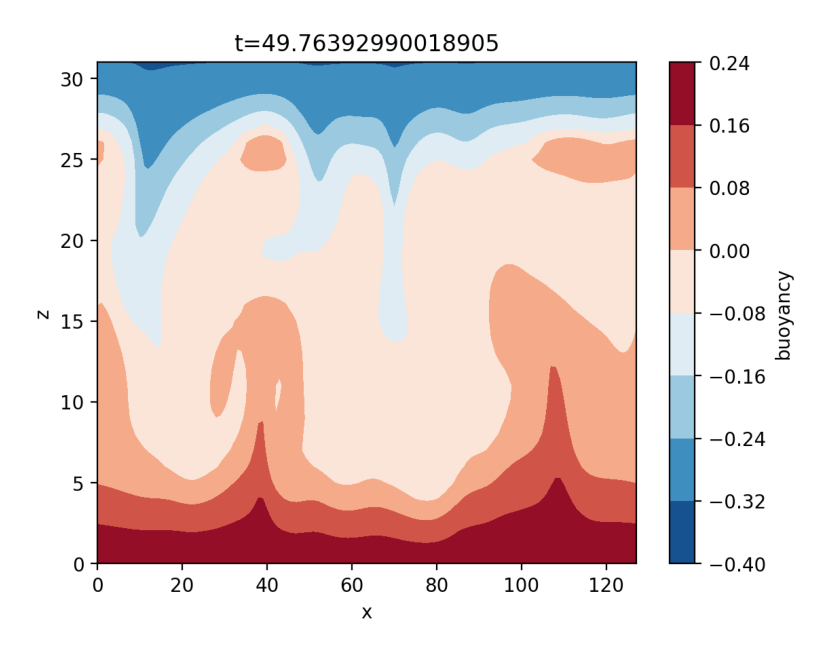

In [12]:
import matplotlib.animation as Animation
from PIL import Image


folder_dir = 'buoyancygraph'

# Get a list of PNG file paths from the directory
file_paths = [os.path.join(folder_dir, f) for f in listdir(folder_dir) if os.path.isfile(os.path.join(folder_dir, f)) and f.endswith('.png')]

# Sort the list of file paths
file_paths.sort()

# Read the images using PIL
imgs = [Image.open(f) for f in file_paths]

fig = plt.figure(figsize=(16,4),dpi=200)
fig.patch.set_visible(False)
plt.axis('off')

# Wrap each image in a list to create a list of sequences of artists
imgs = [[plt.imshow(img, animated=True)] for img in imgs]

ani = Animation.ArtistAnimation(fig, imgs, interval=250, blit=True, repeat_delay=1000)

# Save the animation to a file
ani.save('buoyancygraph.gif',dpi=200)


In [3]:
folder_dir = "snapshots"

file_paths = [os.path.join(folder_dir, file) for file in listdir(folder_dir) if os.path.isfile(os.path.join(folder_dir, file)) and file.endswith('.h5')]
file_paths.sort()
print(file_paths)

['snapshots/snapshots_s1.h5', 'snapshots/snapshots_s2.h5', 'snapshots/snapshots_s3.h5', 'snapshots/snapshots_s4.h5']


In [15]:
if not os.path.exists('liquid water'):    
    os.mkdir('liquid water')
n=0
for file in file_paths:
    with h5py.File(file, mode='r') as file:
        moistbuoyancy = file['tasks']['moist buoyancy']
        drybuoyancy = file['tasks']['dry buoyancy']
        ql=np.maximum(moistbuoyancy[:]-drybuoyancy[:]+N_s2*z,0)
        st = file['scales/sim_time']
        for t in range(50):
            qli=np.transpose(ql[t,:,:,16])
            plt.contourf(qli, cmap='RdBu_r')
            plt.colorbar(label='liquid water')
            plt.xlabel('x')
            plt.ylabel('z')
            n=n+1
            # Add time title
            title = "t="+str(st[t])
            plt.title(title)
            plt.savefig('liquid water/liquidwater_'+"%04d"%n+'.png', dpi=200,bbox_inches='tight')
            matplotlib.pyplot.close()

2023-06-24 21:18:23,267 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2023-06-24 21:18:23,270 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 3200x800 -pix_fmt rgba -r 4.0 -i pipe: -filter_complex 'split [a][b];[a] palettegen [p];[b][p] paletteuse' -y liquidwater.gif


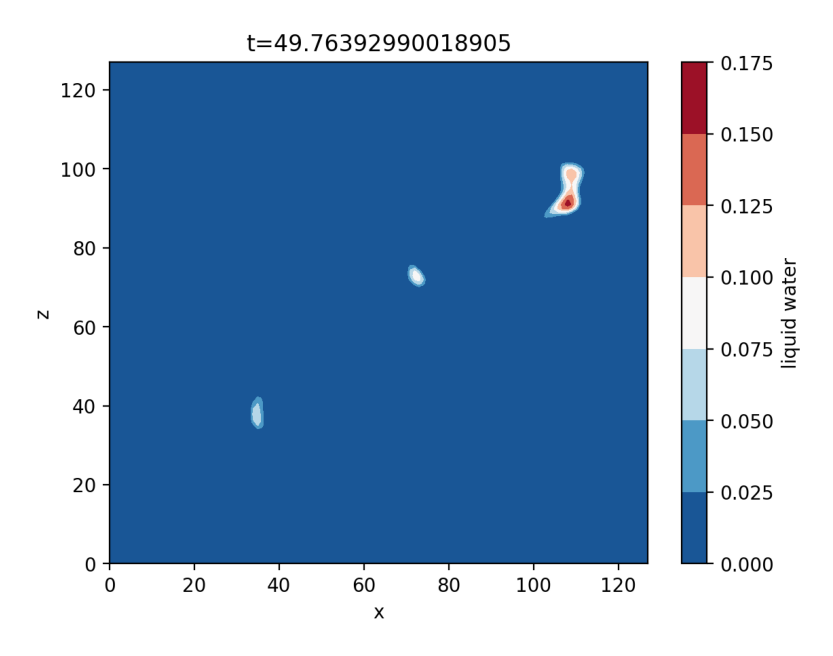

In [16]:
import matplotlib.animation as Animation
from PIL import Image


folder_dir = 'liquid water'

# Get a list of PNG file paths from the directory
file_paths = [os.path.join(folder_dir, f) for f in listdir(folder_dir) if os.path.isfile(os.path.join(folder_dir, f)) and f.endswith('.png')]

# Sort the list of file paths
file_paths.sort()

# Read the images using PIL
imgs = [Image.open(f) for f in file_paths]

fig = plt.figure(figsize=(16,4),dpi=200)
fig.patch.set_visible(False)
plt.axis('off')

# Wrap each image in a list to create a list of sequences of artists
imgs = [[plt.imshow(img, animated=True)] for img in imgs]

ani = Animation.ArtistAnimation(fig, imgs, interval=250, blit=True, repeat_delay=1000)

# Save the animation to a file
ani.save('liquidwater.gif',dpi=200)

In [7]:
folder_dir = "snapshots"

file_paths = [os.path.join(folder_dir, file) for file in listdir(folder_dir) if os.path.isfile(os.path.join(folder_dir, file)) and file.endswith('.h5')]
file_paths.sort()
print(file_paths)

['snapshots/snapshots_s1.h5', 'snapshots/snapshots_s2.h5', 'snapshots/snapshots_s3.h5', 'snapshots/snapshots_s4.h5']


In [8]:
z1=25
if not os.path.exists('liquid water z='+str(z1)):    
    os.mkdir('liquid water z='+str(z1))
n=0
for file in file_paths:
    with h5py.File(file, mode='r') as file:
        moistbuoyancy = file['tasks']['moist buoyancy']
        drybuoyancy = file['tasks']['dry buoyancy']
        ql=np.maximum(moistbuoyancy[:]-drybuoyancy[:]+N_s2*z,0)
        st = file['scales/sim_time']
        for t in range(50):
            qli=np.transpose(ql[t,:,:,z1])
            plt.contourf(qli, cmap='RdBu_r')
            plt.colorbar(label='liquid water z='+str(z1))
            plt.xlabel('x')
            plt.ylabel('z')
            n=n+1
            # Add time title
            title = "t="+str(st[t])
            plt.title(title)
            plt.savefig('liquid water z=25/liquidwater_z=25_'+"%04d"%n+'.png', dpi=200,bbox_inches='tight')
            matplotlib.pyplot.close()

In [9]:
import matplotlib.animation as Animation
from PIL import Image


folder_dir = 'liquid water z='+str(z1)

# Get a list of PNG file paths from the directory
file_paths = [os.path.join(folder_dir, f) for f in listdir(folder_dir) if os.path.isfile(os.path.join(folder_dir, f)) and f.endswith('.png')]

# Sort the list of file paths
file_paths.sort()

# Read the images using PIL
imgs = [Image.open(f) for f in file_paths]

fig = plt.figure(figsize=(16,4),dpi=200)
fig.patch.set_visible(False)
plt.axis('off')

# Wrap each image in a list to create a list of sequences of artists
imgs = [[plt.imshow(img, animated=True)] for img in imgs]

ani = Animation.ArtistAnimation(fig, imgs, interval=250, blit=True, repeat_delay=1000)

# Save the animation to a file
ani.save('liquidwater z='+str(z1)+'.gif',dpi=200)

2023-06-25 00:10:16,401 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
2023-06-25 00:10:16,404 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 3200x800 -pix_fmt rgba -r 4.0 -i pipe: -filter_complex 'split [a][b];[a] palettegen [p];[b][p] paletteuse' -y 'liquidwater z=25.gif'
